<a href="https://colab.research.google.com/github/AlifeviousChristian/Batteries-State-Of-Health-Estimation/blob/main/LSTM_Charging70.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preparation of The Dataset

In [1]:
# To install the kaggle connnector

!pip install kaggle

In [2]:
# To allow the GDrive connection to this notebook

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# This is to configure that our dataset will be saved at /content/drive/MyDrive/Thesis

import os
os.chdir("/content/drive/MyDrive/Thesis")

## Analyzing the data and creating the LSTM model
Refer to https://youtu.be/c0k-YLQGKjY?si=7rK46NGHURBgLNE2

In [4]:
# This is to import all necesary libraries

import tensorflow as tf
import pandas as pd
import numpy as np

In [5]:
df = pd.read_csv("/content/drive/MyDrive/Thesis/70SOCDatasetOnly.csv") #Based on the dataset information, all value is in MWs
df

,No,SoC
0,0.0,68.888485
1,1.0,68.888485
2,2.0,68.888485
3,3.0,82.222424
4,4.0,83.704647
...,...,...
164,164.0,100.000000
165,165.0,100.000000
166,166.0,100.000000
167,167.0,100.000000


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
df

,No,SoC
0,0.0,68.888485
1,1.0,68.888485
2,2.0,68.888485
3,3.0,82.222424
4,4.0,83.704647
...,...,...
164,164.0,100.000000
165,165.0,100.000000
166,166.0,100.000000
167,167.0,100.000000


<Axes: >

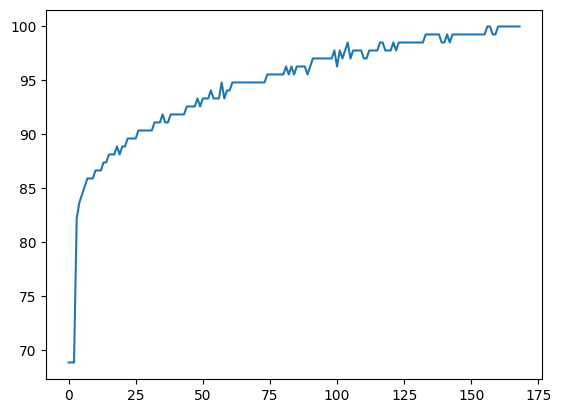

In [8]:
elec = df['SoC'] # All values devided by 1000 to normalize the data since our the data is quite big
elec.plot() # Plot the dataset

In [9]:
# We are going to create a matrix like bellow :
# [[[1], [2], [3], [4], [5]]] [6]
# [[[2], [3], [4], [5], [6]]] [7]
# [[[3], [4], [5], [6], [7]]] [8]

def df_to_X_y(df, window_size=3):
  df_as_np = df.to_numpy()
  X = []
  y = []

  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [10]:
WINDOW_SIZE = 3
X1, y1 = df_to_X_y(elec, WINDOW_SIZE)
X1.shape, y1.shape

((166, 3, 1), (166,))

In [11]:
# This is to devide the dataset into train, validation, and test set.

X_train1, y_train1 = X1[:120], y1[:120]
X_val1, y_val1 = X1[120:150], y1[120:150]
X_test1, y_test1 = X1[150:], y1[150:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((120, 3, 1), (120,), (30, 3, 1), (30,), (16, 3, 1), (16,))

In [12]:
# Creating a LSTM model using tensorflow-keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model1 = Sequential()
model1.add(InputLayer((3, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Configuring the optimizer

cp1 = ModelCheckpoint('model1/model.keras', save_best_only=True) # Add '.keras' to the end of the filepath
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

history=model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=500, callbacks=[cp1])
model1.save('model1/model.keras') #This will save your model

Epoch 1/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 397ms/step - loss: 8926.4209 - root_mean_squared_error: 94.4786 - val_loss: 9878.8174 - val_root_mean_squared_error: 99.3922
Epoch 2/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 8829.1084 - root_mean_squared_error: 93.9631 - val_loss: 9806.6748 - val_root_mean_squared_error: 99.0287
Epoch 3/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 8753.8750 - root_mean_squared_error: 93.5620 - val_loss: 9736.6660 - val_root_mean_squared_error: 98.6745
Epoch 4/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 8581.6162 - root_mean_squared_error: 92.6347 - val_loss: 9667.8252 - val_root_mean_squared_error: 98.3251
Epoch 5/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 8604.4512 - root_mean_squared_error: 92.7601 - val_loss: 9620.2539 - val_root_mean_squared_error: 98.0829
Epoch 6/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 8627.5430 - root_mean_squared_error: 92.8839 - val_loss: 9564.0996 - val_root_mean_squared_error: 97.7962
Epoch 7/500
4/4

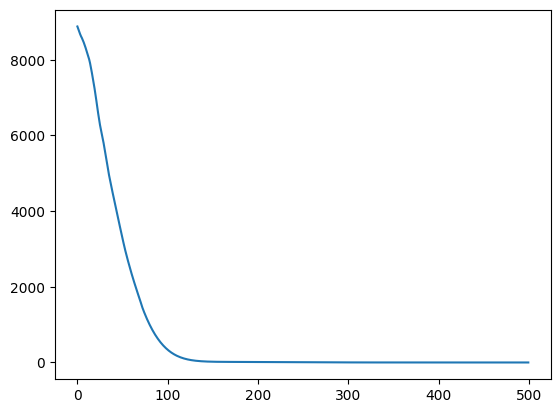

In [14]:
# To load trained model
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
model1 = load_model('model1/model.keras')

loss_per_epoch = history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [15]:
train_predictions = model1.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train predictions':train_predictions, 'Actuals':y_train1})
train_results['Error'] = abs(train_results['Actuals'] - train_results['Train predictions'])
train_results['Percentage Error (%)'] = (train_results['Error'] / train_results['Actuals']) * 100
train_results

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


,Train predictions,Actuals,Error,Percentage Error (%)
0,78.594040,82.222424,3.628384,4.412889
1,83.539352,83.704647,0.165294,0.197473
2,84.517723,84.444242,0.073481,0.087017
3,84.856331,85.186869,0.330538,0.388016
4,85.416367,85.926465,0.510098,0.593645
...,...,...,...,...
115,97.747292,97.778182,0.030890,0.031592
116,97.319992,97.778182,0.458190,0.468601
117,97.176804,97.778182,0.601378,0.615043
118,97.190620,98.517778,1.327157,1.347125


In [16]:
import matplotlib.pyplot as plt


avg_error = train_results['Error'].mean()
max_error = train_results['Error'].max()
min_error = train_results['Error'].min()

print(f"Average Error: {avg_error}")
print(f"Maximum Error: {max_error}")
print(f"Minimum Error: {min_error}")

Average Error: 0.4816646817332373
Maximum Error: 3.6283843830078126
Minimum Error: 0.030890365058596103


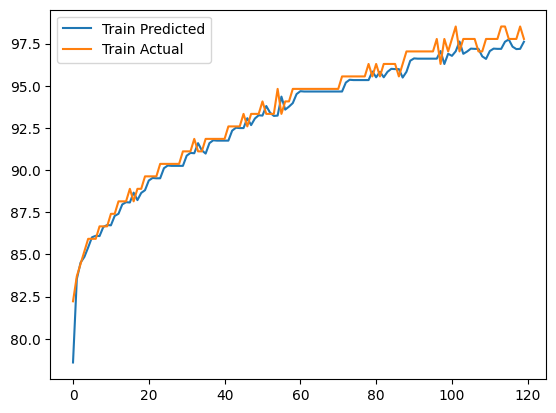

In [17]:
import matplotlib.pyplot as plt
plt.plot(train_results['Train predictions'], label='Train Predicted')
plt.plot(train_results['Actuals'], label='Train Actual')
plt.legend()

In [18]:
val_predictions = model1.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Val predictions':val_predictions, 'Actuals':y_val1})
val_results['Error val'] = abs(val_results['Actuals'] - val_results['Val predictions'])
val_results['Percentage Error val (%)'] = (val_results['Error val'] / val_results['Actuals']) * 100
val_results

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


,Val predictions,Actuals,Error val,Percentage Error val (%)
0,97.333641,98.517778,1.184137,1.201952
1,97.598915,98.517778,0.918862,0.932687
2,97.747292,98.517778,0.770486,0.782078
3,97.734428,98.517778,0.783349,0.795135
4,97.734428,98.517778,0.783349,0.795135
5,97.734428,98.517778,0.783349,0.795135
6,97.734428,98.517778,0.783349,0.795135
7,97.734428,98.517778,0.783349,0.795135
8,97.734428,98.517778,0.783349,0.795135
9,97.734428,98.517778,0.783349,0.795135


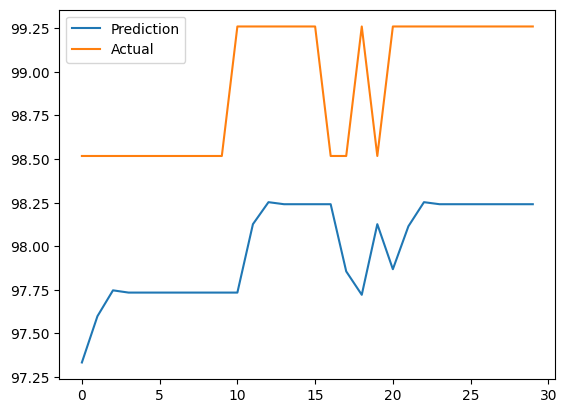

In [19]:
import matplotlib.pyplot as plt
plt.plot(val_results['Val predictions'][:1000], label='Prediction') # Changed 'Train Predictions' to 'Train Predicted'
plt.plot(val_results['Actuals'][:1000], label='Actual') # Changed 'Actuals' to 'Train Actual'
plt.legend()

In [20]:
test_predictions = model1.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Test predictions':test_predictions, 'Actuals':y_test1})
test_results['Error test'] = abs(test_results['Actuals'] - test_results['Test predictions'])
test_results['Percentage Error val (%)'] = (test_results['Error test'] / val_results['Actuals']) * 100
test_results

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


,Test predictions,Actuals,Error test,Percentage Error val (%)
0,98.241196,99.260404,1.019209,1.034543
1,98.241196,99.260404,1.019209,1.034543
2,98.241196,99.260404,1.019209,1.034543
3,98.241196,100.000000,1.758804,1.785266
4,98.601051,100.000000,1.398949,1.419996
5,98.716721,99.260404,0.543684,0.551864
6,98.353485,99.260404,0.906919,0.920564
7,98.229752,100.000000,1.770248,1.796882
8,98.601051,100.000000,1.398949,1.419996
9,98.716721,100.000000,1.283279,1.302587


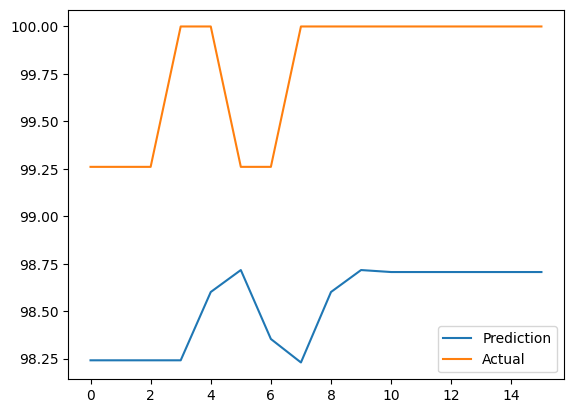

In [21]:
import matplotlib.pyplot as plt
plt.plot(test_results['Test predictions'][:7800], label='Prediction') # Changed 'Train Predictions' to 'Train Predicted'
plt.plot(test_results['Actuals'][:7800], label='Actual') # Changed 'Actuals' to 'Train Actual'
plt.legend()

Analyzing the data and creating the CNN model

## Analyzing the data and creating the CNN model
Refer to https://www.youtube.com/watch?v=kGdbPnMCdOg&t=1320s

In [22]:
from sklearn.metrics import mean_squared_error as mse

def plot_predictions(model, X, y, start=0, end=7800):
    predictions = model.predict(X).flatten()
    df = pd.DataFrame(data={'Predictions': predictions, 'Actuals': y})
    plt.plot(df['Predictions'][start:end])
    plt.plot(df['Actuals'][start:end])
    plt.legend(['Predictions', 'Actuals'])
    return df, mse(y, predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


(    Predictions     Actuals
 0     98.241196   99.260404
 1     98.241196   99.260404
 2     98.241196   99.260404
 3     98.241196  100.000000
 4     98.601051  100.000000
 5     98.716721   99.260404
 6     98.353485   99.260404
 7     98.229752  100.000000
 8     98.601051  100.000000
 9     98.716721  100.000000
 10    98.706261  100.000000
 11    98.706261  100.000000
 12    98.706261  100.000000
 13    98.706261  100.000000
 14    98.706261  100.000000
 15    98.706261  100.000000,
 1.6290696851241833)

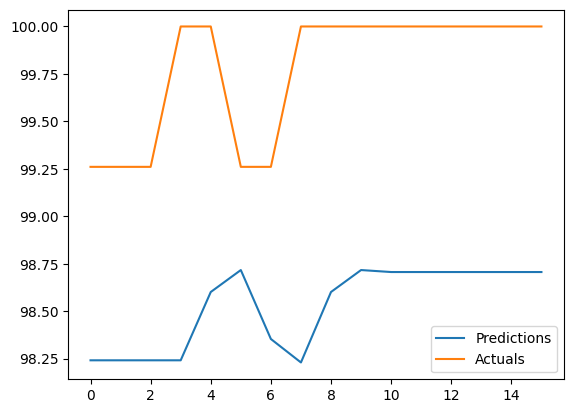

In [23]:
plot_predictions(model1, X_test1, y_test1)

In [24]:
model2 = Sequential()
model2.add(InputLayer((3, 1)))
model2.add(Conv1D(64, kernel_size = 2))
model2.add(Flatten())
model2.add(Dense(8, 'relu'))
model2.add(Dense(1, 'linear'))

model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 2, 64)          │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │         1,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,233 (4.82 KB)

 Trainable params: 1,233 (4.82 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# Configuring the optimizer

cp2 = ModelCheckpoint('model2/model.keras', save_best_only=True) # Add '.keras' to the end of the filepath
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

history2=model2.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=500, callbacks=[cp2])
model2.save('model2/model.keras') #This will save your model

Epoch 1/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 202ms/step - loss: 9846.1035 - root_mean_squared_error: 99.2117 - val_loss: 9947.2676 - val_root_mean_squared_error: 99.7360
Epoch 2/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 8883.2852 - root_mean_squared_error: 94.2507 - val_loss: 9815.4980 - val_root_mean_squared_error: 99.0732
Epoch 3/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 8777.3740 - root_mean_squared_error: 93.6876 - val_loss: 9792.0596 - val_root_mean_squared_error: 98.9548
Epoch 4/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 8771.9648 - root_mean_squared_error: 93.6586 - val_loss: 9785.8320 - val_root_mean_squared_error: 98.9234
Epoch 5/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 8712.1826 - root_mean_squared_error: 93.3385 - val_loss: 9785.0449 - val_root_mean_squared_error: 98.9194
Epoch 6/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 8812.2842 - root_mean_squared_error: 93.8728 - val_loss: 9784.2588 - val_root_mean_squared_error: 98.9154
Epoch 7/500
4/4

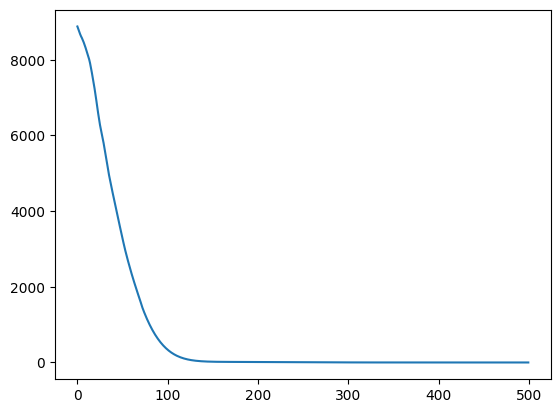

In [26]:
# To load trained model
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
model2 = load_model('model2/model.keras')

loss_per_epoch = history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [27]:
test_predictions2 = model2.predict(X_test1).flatten()
test_results2 = pd.DataFrame(data={'Test predictions':test_predictions2, 'Actuals':y_test1})
test_results2['Error test'] = test_results2['Actuals'] - test_results2['Test predictions']
test_results2['Percentage Error test (%)'] = (test_results2['Error test'] / test_results2['Actuals']) * 100
test_results2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


,Test predictions,Actuals,Error test,Percentage Error test (%)
0,1.990898,99.260404,97.269506,97.994267
1,1.990898,99.260404,97.269506,97.994267
2,1.990898,99.260404,97.269506,97.994267
3,1.990898,100.000000,98.009102,98.009102
4,1.990898,100.000000,98.009102,98.009102
5,1.990898,99.260404,97.269506,97.994267
6,1.990898,99.260404,97.269506,97.994267
7,1.990898,100.000000,98.009102,98.009102
8,1.990898,100.000000,98.009102,98.009102
9,1.990898,100.000000,98.009102,98.009102


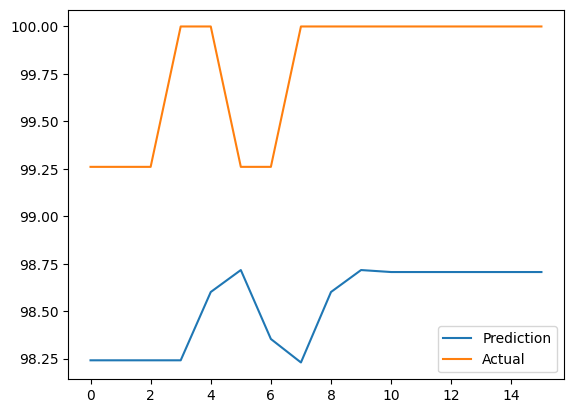

In [28]:
import matplotlib.pyplot as plt
plt.plot(test_results['Test predictions'][:7800], label='Prediction') # Changed 'Train Predictions' to 'Train Predicted'
plt.plot(test_results['Actuals'][:7800], label='Actual') # Changed 'Actuals' to 'Train Actual'
plt.legend()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


(    Predictions     Actuals
 0      1.990898   99.260404
 1      1.990898   99.260404
 2      1.990898   99.260404
 3      1.990898  100.000000
 4      1.990898  100.000000
 5      1.990898   99.260404
 6      1.990898   99.260404
 7      1.990898  100.000000
 8      1.990898  100.000000
 9      1.990898  100.000000
 10     1.990898  100.000000
 11     1.990898  100.000000
 12     1.990898  100.000000
 13     1.990898  100.000000
 14     1.990898  100.000000
 15     1.990898  100.000000,
 9560.650499447405)

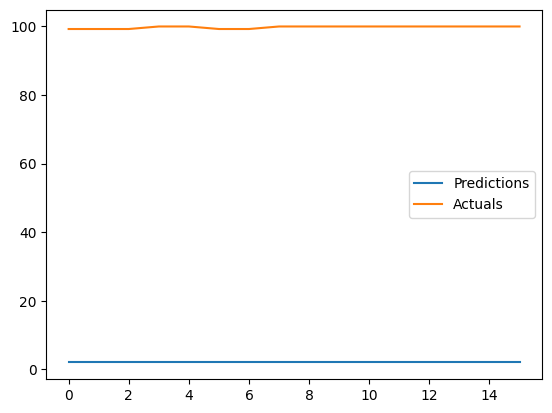

In [29]:
plot_predictions(model2, X_test1, y_test1)

In [30]:
import matplotlib.pyplot as plt

avg_error = test_results2['Percentage Error test (%)'].mean()
max_error = test_results2['Percentage Error test (%)'].max()
min_error = test_results2['Percentage Error test (%)'].min()

print(f"Average Error: {abs(avg_error)}","%")
print(f"Maximum Error: {max_error}","%")
print(f"Minimum Error: {abs(min_error)}","%")

Average Error: 98.00446590686042 %
Maximum Error: 98.0091016292572 %
Minimum Error: 97.99426731758744 %


Analyzing